In [1]:
import pandas as pd
import os
import shutil
import glob
import numpy as np

# Essential Libraries
import cv2
import pandas as pd
import matplotlib.pyplot as plt

#import av   # !pip install av
import numpy as np
import os
import torch
from transformers import VivitConfig, VivitModel, VivitImageProcessor
from torchvision.transforms import Compose, Resize, Lambda, ToTensor, ToPILImage
from PIL import Image

# Display plots inline
%matplotlib inline

# Set plot parameters
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['axes.grid'] = False
plt.style.use('dark_background')
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15

In [17]:
# import av   # !pip install av
# import os

# fpath = "/Users/mikehemberger/Documents/vscode/totems/data/data-prototype/dataset_v1/"
# fname = "MVI_7423_pulse_wabbern-cropped"
# vid_filename = fname + ".mp4"
# os.makedirs(fpath + fname + '/images-from-av', exist_ok=True)
# container = av.open(os.path.join(fpath + fname, vid_filename))

# for frame in container.decode(video=0):
#    frame.to_image().save(fpath + fname + '/images-from-av/frame_%04d.jpg' % frame.index)

deprecated pixel format used, make sure you did set range correctly
 (repeated 85 more times)


In [2]:
# Transfers data from roboflow download folder to data/data-prototype
copy_files = False

source_dir = '/Users/mikehemberger/Documents/vscode/totems/data/roboflow-dataset-download/totem-prototype.v1i.yolov7pytorch/'
target_dir = "./data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/"
os.makedirs(os.path.join(target_dir, "images/renamed/"), exist_ok=True)
z_fill_ = 4

if copy_files:
    os.makedirs(target_dir, exist_ok=True)
    prefix = "MVI_7423_pulse_wabbern-cropped_mp4-"
    # Find all jpg and txt files in the source directory and its subdirectories
    for filename in glob.glob(source_dir + '/**/*.jpg', recursive=True):
        if os.path.basename(filename).startswith(prefix):
            renamed = str(os.path.basename(filename).split(prefix)[1].split("_jpg")[0]).zfill(z_fill_) # .split(prefix)[1]
            renamed_filename = "frame_" + renamed + ".jpg"
            destination = os.path.join(target_dir, "images/renamed/", renamed_filename)
            shutil.copyfile(filename, destination)

    for filename in glob.glob(source_dir + '/**/*.txt', recursive=True):
        if os.path.basename(filename).startswith(prefix):
            renamed = str(os.path.basename(filename).split(prefix)[1].split("_jpg")[0]).zfill(z_fill_) # .split(prefix)[1]
            renamed_filename = "frame_" + renamed + ".txt"
            destination = os.path.join(target_dir, "images/renamed/", renamed_filename)
            shutil.copyfile(filename, destination)


In [4]:
target_dir = "./data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images/renamed/"
filenames = sorted([f for f in os.listdir(target_dir) if f.endswith(".jpg")])
target_fpaths = [os.path.join(target_dir, f) for f in os.listdir(target_dir) if f.endswith(".jpg")]

df = pd.DataFrame(columns=["filename", "frame_idx", "frame_sec", "filepath", "cutout_fpath", "frame_str", "frame_int"])
sr = 40  # sampling rate
df["filename"] = filenames
df["frame_idx"] = [int(n) for n in range(len(df))]
df["frame_sec"] = df["frame_idx"] * sr  # 25hz, 40ms sr
df["filepath"] = target_fpaths
df["frame_int"] = [int(fn.split("frame_")[-1].split(".jpg")[0]) for fn in df["filename"].tolist()] #  .astype("int64")

# Save the dataframe
df.to_csv(os.path.join(target_dir, "prototype-v1-mvi-7423.csv"), index=False)
len(df)

805

In [5]:
# Load the dataframe
df = pd.read_csv(os.path.join(target_dir, "prototype-v1-mvi-7423.csv"))
T_idx = df["frame_idx"].max()

df = df.sort_values(by="frame_idx")

df["filepath_txt"] = sorted(df["filepath"].str.replace(".jpg", ".txt"))
df["ori_filepath"] = sorted(df["filepath"].str.replace("images/renamed","images-from-av"))
df = df.iloc[:-1]

print(len(df))
print(df["filepath_txt"].tolist()[:5])
print(df["ori_filepath"].tolist()[:5])
df.head()

804
['./data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0000.txt', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0001.txt', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0002.txt', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0003.txt', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0004.txt']
['./data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images-from-av/frame_0000.jpg', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images-from-av/frame_0001.jpg', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images-from-av/frame_0002.jpg', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images-from-av/frame_0003.jpg', './data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped/images-from-av/frame_0004.jpg']


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_795/3680822996.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df["filepath_txt"] = sorted(df["filepath"].str.replace(".jpg", ".txt"))


,filename,frame_idx,frame_sec,filepath,cutout_fpath,frame_str,frame_int,filepath_txt,ori_filepath
0,frame_0000.jpg,0,0,./data/data-prototype/dataset_v1/MVI_7423_puls...,NaN,NaN,0,./data/data-prototype/dataset_v1/MVI_7423_puls...,./data/data-prototype/dataset_v1/MVI_7423_puls...
1,frame_0001.jpg,1,40,./data/data-prototype/dataset_v1/MVI_7423_puls...,NaN,NaN,1,./data/data-prototype/dataset_v1/MVI_7423_puls...,./data/data-prototype/dataset_v1/MVI_7423_puls...
2,frame_0002.jpg,2,80,./data/data-prototype/dataset_v1/MVI_7423_puls...,NaN,NaN,2,./data/data-prototype/dataset_v1/MVI_7423_puls...,./data/data-prototype/dataset_v1/MVI_7423_puls...
3,frame_0003.jpg,3,120,./data/data-prototype/dataset_v1/MVI_7423_puls...,NaN,NaN,3,./data/data-prototype/dataset_v1/MVI_7423_puls...,./data/data-prototype/dataset_v1/MVI_7423_puls...
4,frame_0004.jpg,4,160,./data/data-prototype/dataset_v1/MVI_7423_puls...,NaN,NaN,4,./data/data-prototype/dataset_v1/MVI_7423_puls...,./data/data-prototype/dataset_v1/MVI_7423_puls...


In [6]:
from PIL import Image
import cv2

# resize
src = os.path.join("./data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped", "images/renamed/")
src_ = os.path.join("./data/data-prototype/dataset_v1/MVI_7423_pulse_wabbern-cropped", "images-224/")
os.makedirs(src_, exist_ok=True)

filenames = sorted([f for f in os.listdir(src) if f.endswith(".jpg")])
resize = (224, 224)

# for fn in filenames:
#     img = Image.open(src+fn).resize(resize)
#     img.save(src_+fn)

In [7]:
annots = df["filepath_txt"].tolist()
filenames = df["filename"].tolist()
img_filepaths = df["ori_filepath"].tolist()

d = dict()

for idx, annot in enumerate(annots):
    im = Image.open(img_filepaths[idx])
    im_width, im_height = im.size

    with open(annot, 'r') as f:
        lines = f.read().splitlines()

        for nth, line in enumerate(lines):
            values = list(map(float, line.strip().split()))

            while values:
                class_id = int(values.pop(0))
                x_values = []
                y_values = []
                while values and len(values) >= 2:
                    x_values.append(values.pop(0))
                    y_values.append(values.pop(0))
                    x1 = int(min(x_values) * im_width)
                    y1 = int(min(y_values) * im_height)
                    x2 = int(max(x_values) * im_width)
                    y2 = int(max(y_values) * im_height)
                d.update({filenames[idx].split(".jpg")[0] + "_" + str(nth): np.array([[x1, x2],[y1, y2]])})

# spatial central point of bbox cluster sets to determine reliable LED position (can be ON and OFF)

In [27]:


def get_bbox(df:dict, frame:str):
    x = df[frame][0,0], df[frame][0,1], df[frame][0,1], df[frame][0,0], df[frame][0,0]
    y = df[frame][1,0], df[frame][1,0], df[frame][1,1], df[frame][1,1], df[frame][1,0]

    return np.vstack((x,y)).T

search_list = list(d.keys()) 
means = list()
for nth in range(len(search_list)):
    search_for = f"frame_{str(nth).zfill(z_fill_)}_"#'frame_0000_'
    result_keys = [f for f in search_list if f.startswith(search_for)]

    bboxes = []
    for key in result_keys:
        means.append([np.mean(get_bbox(d, key)[:,0]), np.mean(get_bbox(d, key)[:,1])])


In [28]:
from sklearn.cluster import KMeans

cmap = plt.cm.jet
means_ = np.array(means)
colors = cmap(np.linspace(0, 1, len(means_)))[:,:3]

kmeans = KMeans(n_clusters=35, random_state=0)
kmeans.fit(means_)
assignments = kmeans.labels_
centers = kmeans.cluster_centers_
print("clusters", max(assignments))

clusters 34


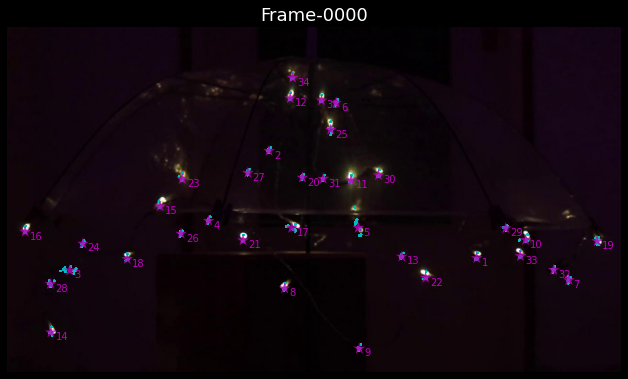

In [58]:
pixshiftx = 10
pixshifty = 15

plt.figure(figsize=(11,11))
plt.title("Frame-0000")
plt.imshow(Image.open(df.loc[0,"ori_filepath"]))
plt.axis("off")
plt.savefig("./data/data-prototype/dataset_v1/Frame-0000-RAW.jpg", dpi=300)

plt.scatter(means_[:,0], means_[:,1], color="c", alpha=.75, marker=".", edgecolors="none", s=15)
plt.scatter(centers[:,0], centers[:,1], color="m", alpha=.8, marker="*", edgecolors="none", s=150)

labels = list(map(str, range(1, len(centers) + 1)))
for i in range(len(centers)):
    plt.text(centers[i,0] + pixshiftx, centers[i,1] + pixshifty, labels[i], fontdict={"fontsize" : 10, "color" : "m"})

plt.tight_layout()
plt.savefig("./data/data-prototype/dataset_v1/Frame-0000-Illustration.jpg", dpi=300)


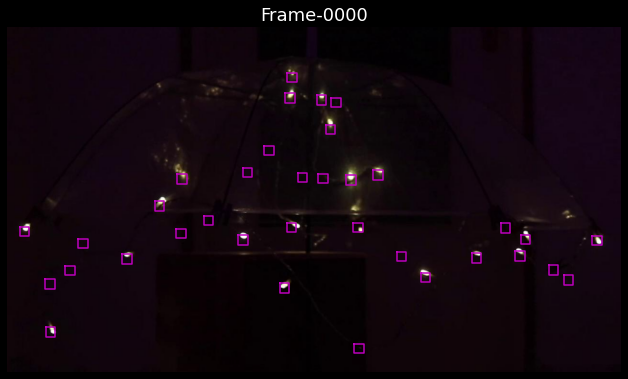

In [77]:
xoffset = 10
yoffset = 10
bboxes_ = list()

for c__ in centers:
    x, y = c__
    x_min = max(0, x - xoffset)
    y_min = max(0, y - yoffset)
    x_max = x + xoffset
    y_max = y + yoffset
    bboxes_.append([int(y_min), int(y_max), int(x_min), int(x_max)])


plt.figure(figsize=(11,11))
plt.title("Frame-0000")
plt.imshow(Image.open(df.loc[0,"ori_filepath"]))
plt.axis("off")

for bbox in bboxes_:
    plt.plot(
        [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
        [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
        "-m")
plt.tight_layout()
plt.savefig("./data/data-prototype/dataset_v1/Frame-0000-Illustration_BBoxes.jpg", dpi=300)

In [92]:
xframes = [int(n) for n in range(len(df))]
mat = np.zeros((len(xframes), len(centers)))

for ith, bbox in enumerate(bboxes_):
    y_min, y_max, x_min, x_max = bbox

    for nth in xframes:
        intensity_matrix = np.array(Image.open(df.loc[nth, "ori_filepath"]))
        roi = intensity_matrix[int(y_min):int(y_max), int(x_min):int(x_max)]
        mat[nth, ith] = np.mean(roi) #/ (20*20)

np.max(mat)
#np.min(mat)

236.75

# RAW SIGNAL

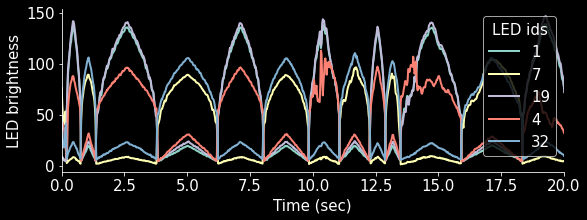

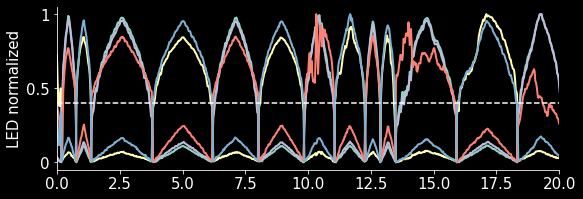

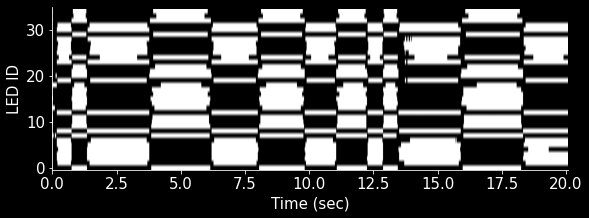

In [248]:
numbers = np.arange(35)  # This creates an array with numbers from 0 to 35
n_signals = 5
sample = np.random.choice(numbers, size=n_signals, replace=False)
tvec  = [x  / 40 for x in xframes]

# PLOT 1
plt.figure(figsize=(9,3))
plt.plot(tvec, mat[:, sample], lw=2, label=sample);
plt.xlabel("Time (sec)")
plt.ylabel("LED brightness")
plt.xlim([0, 20])
plt.legend(title="LED ids", loc="upper right")
plt.tight_layout()
plt.savefig("./data/data-prototype/dataset_v1/prototype-v1-mvi-7423-annotated-LEDs-sample-raw-brightness.jpg", dpi=300)


# PLOT 2
norm_mat = (mat - mat.min(axis=0)) / (mat - mat.min(axis=0)).max(axis=0)
plt.figure(figsize=(9,3))
plt.plot(tvec, norm_mat[:, sample], lw=2, label=sample);
plt.plot([0,20],[.4, .4],"--w")
plt.yticks(ticks=[0, .5, 1], labels=[0, .5, 1])
plt.ylabel("LED normalized")
plt.xlim([0, 20])
plt.tight_layout()
plt.savefig("./data/data-prototype/dataset_v1/prototype-v1-mvi-7423-annotated-LEDs-sample-normalized-brightness.jpg", dpi=300)

# PLOT 3
led_thres = 0.4
bin_mat = norm_mat > led_thres
plt.figure(figsize=(9.25,3))
plt.imshow(np.transpose(bin_mat), aspect="auto",cmap="gray")
plt.ylim([-.5, 35])
plt.ylabel("LED ID")
plt.xticks(ticks=xframes[::100], labels=tvec[::100]);
plt.xlabel("Time (sec)")
plt.xlim([0, len(tvec)])
plt.tight_layout()
plt.savefig("./data/data-prototype/dataset_v1/prototype-v1-mvi-7423-annotated-LEDs-thresholded-ON-OFF.jpg", dpi=300)

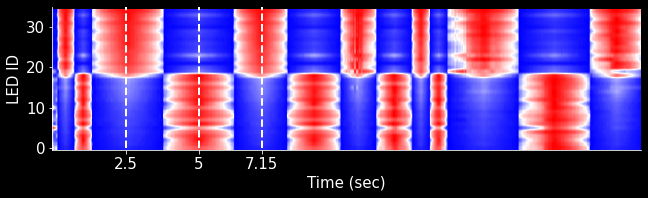

In [334]:
# select three time points
time_points = [2.5, 5, 7.15]  # original [2.5, 5, 17.25]
ccs = ["r", "b", "m"]
tindices = np.where(np.isin(tvec, time_points))[0]
srt_idx = np.where([x == tindices[0] for x in xframes])[0]
df_nmat = pd.DataFrame(norm_mat)

sorted_indices = np.argsort(df_nmat.iloc[srt_idx, :].values)[0]
df_sorted = df_nmat[sorted_indices].copy()
smat = df_sorted.to_numpy()

# PLOT
plt.figure(figsize=(9.25,3))
plt.imshow(np.transpose(smat), aspect="auto", cmap="bwr");

for tp, c in zip(tindices, ccs):
     plt.plot([xframes[tp], xframes[tp]], [0, 35], "--", color="w", lw=2);

plt.xticks(ticks=[xframes[tp] for tp in tindices], labels=[tp for tp in time_points])
plt.ylabel("LED ID")
plt.xlabel("Time (sec)")
plt.ylim([-.5, 35])
plt.xlim([0, len(tvec)])
plt.tight_layout()
plt.savefig("./data/data-prototype/dataset_v1/prototype-v1-mvi-7423-annotated-LEDs-thresholded-normalized-sorted.jpg", dpi=300)


(19, 2) (16, 2)


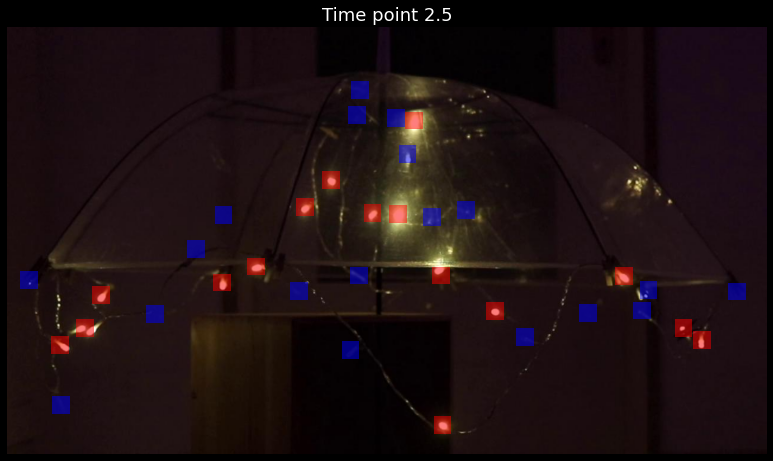

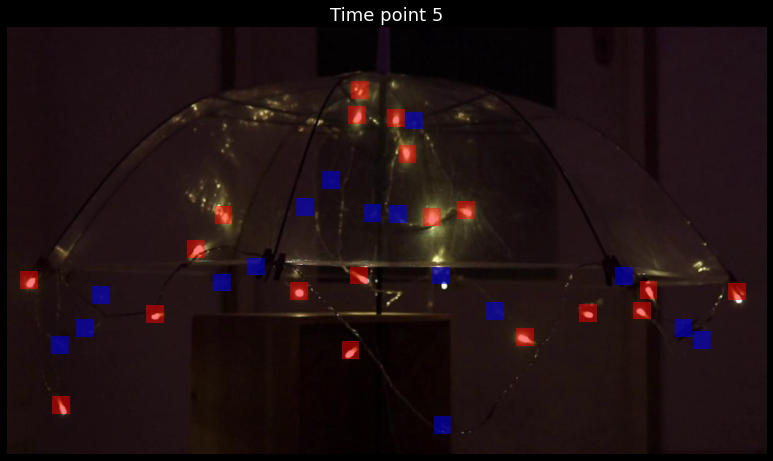

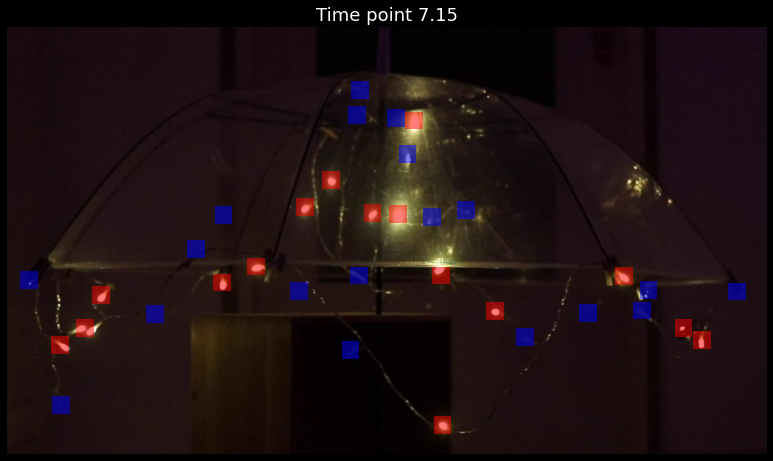

In [335]:
sorted_centers = centers[sorted_indices]
c1, c2 = sorted_centers[:19], sorted_centers[19:]
print(c1.shape, c2.shape)

xoffset = 15
yoffset = 15
sorted_centers = centers[sorted_indices]
color_idx = [["-b", "-r"],["-r", "-b"],["-b", "-r"]]

for tp, ti, ci in zip(time_points, tindices, color_idx):
    bboxes_1 = list()
    bboxes_2 = list()
    for c__ in c1:
        x, y = c__
        x_min = max(0, x - xoffset)
        y_min = max(0, y - yoffset)
        x_max = x + xoffset
        y_max = y + yoffset
        bboxes_1.append([int(y_min), int(y_max), int(x_min), int(x_max)])


    plt.figure(figsize=(11,11))
    plt.title(f"Time point {tp}")
    plt.imshow(Image.open(df.loc[int(xframes[ti]),"ori_filepath"]))
    plt.axis("off")

    for bbox in bboxes_1:
        plt.fill(
            [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
            [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
            ci[0], lw=3, alpha=.5)

    for c__ in c2:
        x, y = c__
        x_min = max(0, x - xoffset)
        y_min = max(0, y - yoffset)
        x_max = x + xoffset
        y_max = y + yoffset
        bboxes_2.append([int(y_min), int(y_max), int(x_min), int(x_max)])


    for bbox in bboxes_2:
        plt.fill(
            [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]],
            [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
            ci[1], lw=3, alpha=.5)
    
    plt.tight_layout()
    plt.savefig(f"./data/data-prototype/dataset_v1/Active-LEDs-timepoint_{tp}_tindex{ti}.jpg", dpi=300)

# Introduce Threshold red-line for .5 of normalized instensity
- also possible to set threshold at around .4 and start with a linear blue7red scale from there till 1.

- Plot bboxes of LEDs first then integrate light

# T-SNE of frames over time
- animate a short .gif version with low fr/sec
- overlap colors, sort by corr coeff (groups), mark valid bboxes with id string, color for clusters

In [9]:
from transformers import ViTFeatureExtractor, ViTModel
feature_extraction = False

if feature_extraction:
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')  # 244-in21k
    model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', return_dict=True)  # 224-in21k

    filenames = df["filename"].tolist()
    feature_vectors = []
    for i, image in enumerate(filenames): 
        image = Image.open(src_+image)
        inputs = feature_extractor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        feature_vector = outputs.pooler_output.detach().cpu().numpy()
        feature_vectors.append(feature_vector)

    feature_vectors = np.concatenate(feature_vectors, axis=0)
    print(feature_vectors.shape)

# Save and Load Feature Vectors

In [10]:
fv_name = "prototype-v1-mvi-7423-feature-vectors-224.npy"
#np.save(os.path.join(src_, fv_name), feature_vectors)
fvs = np.load(os.path.join(src_, fv_name))

In [11]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=50, early_exaggeration=150, learning_rate=45, random_state=42, init="pca")
features_embedded = tsne.fit_transform(fvs)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


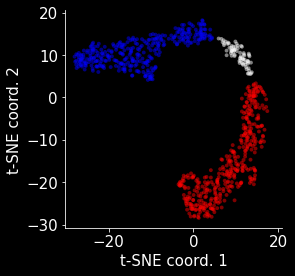

In [12]:
clusters = { #[[xmin, xmax],[ymin, ymax]]
    1 : [[-10, 20], [-30, 4]],
    2 : [[5, 20], [5, 15]],
    3 : [[-30, 4.9], [0, 20]],
}
idxs = list()
for idx, xy in clusters.items():
    xidx = (features_embedded[:, 0] > xy[0][0]) & (features_embedded[:, 0] < xy[0][1])
    yidx = (features_embedded[:, 1] > xy[1][0]) & (features_embedded[:, 1] < xy[1][1])
    idxs.append(np.where((xidx & yidx))[0])

ccolors = ["r", "w", "b"]
plt.figure(figsize=(4,4))
for cidx, c in zip(idxs, ccolors):
    plt.scatter(features_embedded[cidx, 0], features_embedded[cidx, 1], color=c, alpha=.5, edgecolors="none", s=15)
plt.axis("square")
plt.xlabel("t-SNE coord. 1")
plt.ylabel("t-SNE coord. 2")
plt.savefig("./data/data-prototype/dataset_v1/prototype-v1-mvi-7423-fv-tSNE.jpg", dpi=300)

In [13]:
# VIDEO for .gif making
filenames = df["filename"].tolist()
for nth, cid in enumerate(idxs):
    cfilenames = np.array(filenames)[cid]
    frame = cv2.imread(os.path.join(src_, cfilenames[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(src_ + f'video_{int(nth)+1}.avi', 0, 10, (width, height))
    
    for image in cfilenames:
        video.write(cv2.imread(os.path.join(src_, image)))
    cv2.destroyAllWindows()
    video.release()

    # create gifs later

# Plot the cutouts on a black background but at their location!
- this will make it clear I hope!

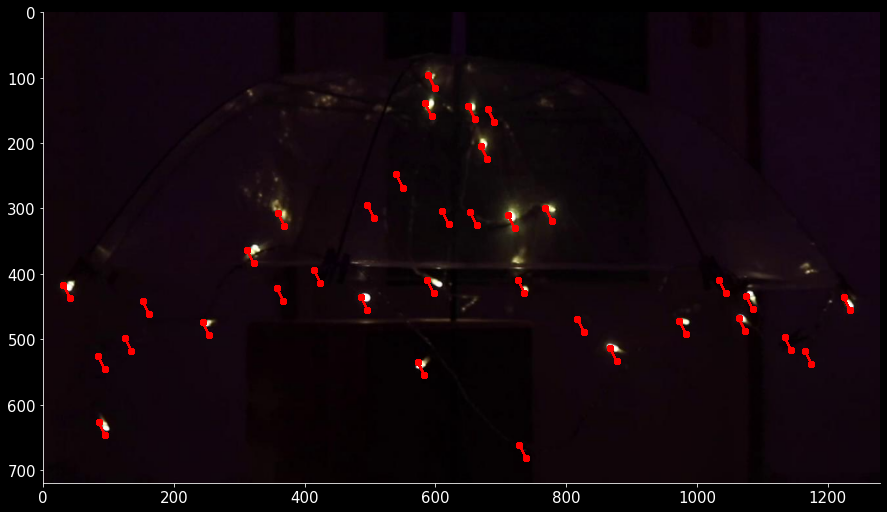

In [16]:
# PLOT IDENTIFIED ROI WITH NUMBERS, THEN USE NUMBERS TO LABEL TRACES / OR COLOR


# GET PLOT BBOX FUNCTION TO PLOT

plt.figure(figsize=(15,15))
plt.imshow(Image.open(df.loc[0,"ori_filepath"]))

for bbox in bbox_:
    plt.plot(
        [bbox[2], bbox[2], bbox[3], bbox[3], bbox[2]],
        [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
        "-or",)



In [51]:
mat.max()

149591.0

In [20]:
mat = pd.DataFrame(mat, columns=[f"center_{n}" for n in range(len(centers))])
mat = mat / mat.mean().mean()
mat = mat / mat.max()
#mat.max().max()
# rollingmean()

In [21]:
# take xframe 483, sorty by activity and use the sorting for visualisation
srt_idx = np.where([x == 483 for x in xframes])[0]
sorted_indices = np.argsort(mat.iloc[srt_idx, :].values)[0]
#mat.iloc[sorted_indices,:]
#sorted_indices

# Introduce Threshold red-line for .5 of normalized instensity
- also possible to set threshold at around .4 and start with a linear blue7red scale from there till 1.

In [ ]:
corrcoeff

(0.0, 35.0)

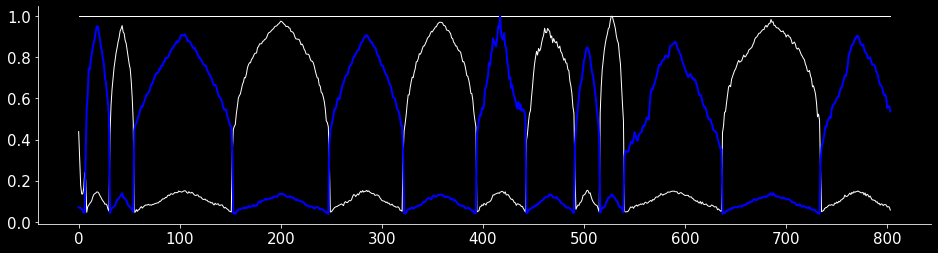

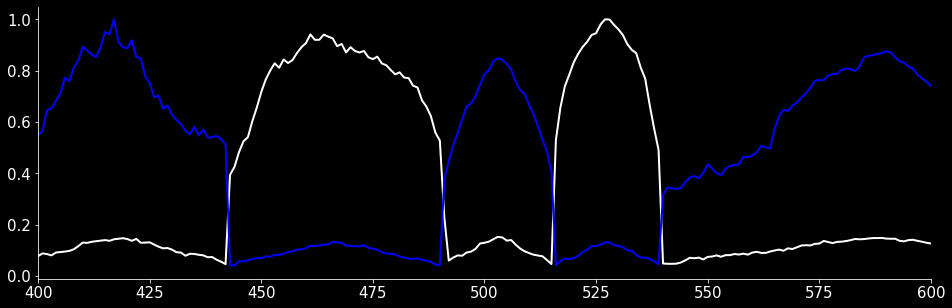

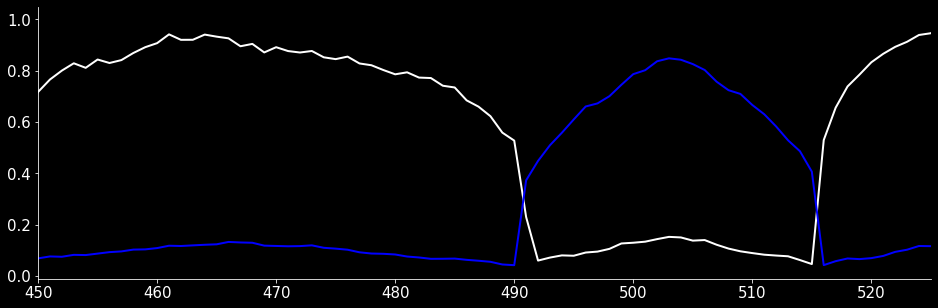

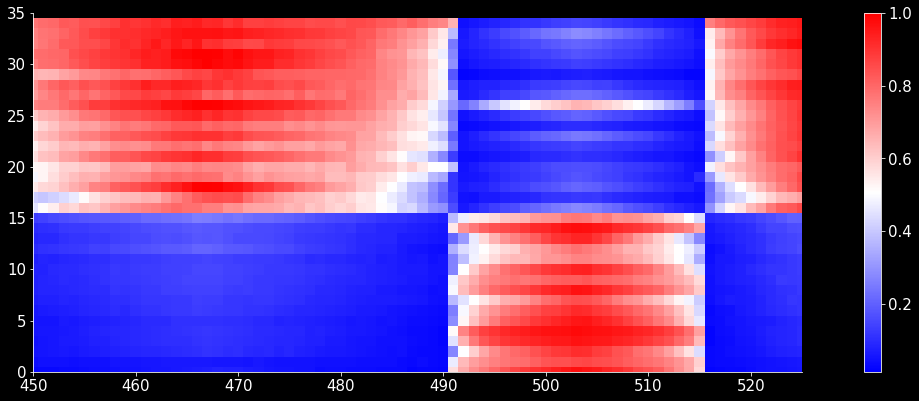

In [22]:
plt.figure(figsize=(16,4))
plt.plot(xframes, np.ones(len(xframes)), "-w", lw=1)
plt.plot(xframes,mat.iloc[:, 0] / max(mat.iloc[:, 0]), "-w", lw=1)
plt.plot(xframes,mat.iloc[:, 2] / max(mat.iloc[:, 2]), "-b", lw=2)

plt.figure(figsize=(16,5))
plt.plot(xframes,mat.iloc[:, 0] / max(mat.iloc[:, 0]), "-w", lw=2)
#plt.plot(xframes,mat.iloc[:, 1] / max(mat.iloc[:, 1]), "-r", lw=2)
plt.plot(xframes,mat.iloc[:, 2] / max(mat.iloc[:, 2]), "-b", lw=2)
plt.xlim([400, 600])

plt.figure(figsize=(16,5))
plt.plot(xframes,mat.iloc[:, 0] / max(mat.iloc[:, 0]), "-w", lw=2)
#plt.plot(xframes,mat.iloc[:, 1] / max(mat.iloc[:, 1]), "-r", lw=2)
plt.plot(xframes,mat.iloc[:, 2] / max(mat.iloc[:, 2]), "-b", lw=2)
plt.xlim([450, 525])

plt.figure(figsize=(22,6.6))
plt.imshow(mat.iloc[:, sorted_indices].T, cmap="bwr")
#plt.axis("square")
plt.colorbar()
plt.xlim([450, 525])
plt.ylim([0, 35])

In [55]:
# cut out clusters and show the averGES!

(200.0, 600.0)

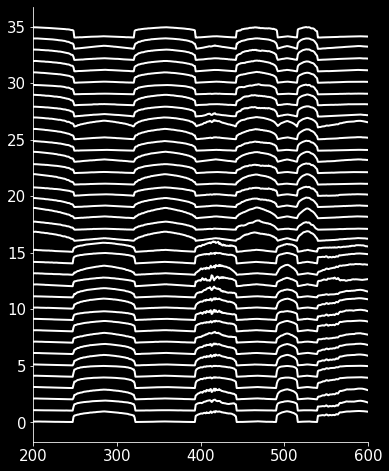

In [23]:
plt.figure(figsize=(6,8))
counter = 0
for ith in sorted_indices:
    plt.plot(xframes, counter + mat.iloc[:, ith], "-w", lw=2)
    counter += 1
    
plt.xlim([200, 600])